In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sklearn
import re
from scipy.spatial.distance import jaccard
from sklearn.cluster import SpectralClustering as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial import distance
from networkx.algorithms.community import k_clique_communities,girvan_newman
import itertools
import datetime

In [2]:
def convertDate(date):
    dates = date.split("-")
    convert = datetime.date(int(dates[0]), int(dates[1]), int(dates[2]))
    return convert

def getThread(num,data):
    thread = data[data["ThreadID"]== threads[num]]
    members = thread["MemberID"].unique()
    thread = thread.reset_index(drop = True)
    
    for i in range(0,len(thread)):
        thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
    
    #encode member names
    index = 0
    for i in range(0,len(members)):
        thread["MemberID"][thread["MemberID"] == members[i]] = index
        index += 1

    thread = thread.sort_values(by = ["P_Date",'MessageID'])
    
    return thread

### Load Data

In [3]:
data = pd.read_csv("../GawaherSentiment.csv")
threads = data["ThreadID"].unique()


### Thread over time

In [4]:
def makeGraph(thread):
    members = thread["MemberID"].unique()
    memberComments = []
    memberSentiments = []

    for i in members:
        memberComments.append(len(thread[thread["MemberID"] == i]))
        memberSentiments.append(thread[thread["MemberID"] == i]["AllenNLP"].iloc[-1])

    #Make graph
    #Make dictionary of nodes (members) with corresponding mean sentiment of that member
    nodes = np.array(members,dtype = int)
    nodeDict = dict(zip(nodes,np.around(memberSentiments,4)))

    edges = []
    for i in range(0,len(thread)-1):
        if thread["MemberID"].iloc[i] != thread["MemberID"].iloc[i +1]:
            edge = (tuple([int(thread["MemberID"].iloc[i]),int(thread["MemberID"].iloc[i+1])]))
            edges.append(edge)

    sortEdges = [np.sort(x) for x in edges]
    edgeKeys = np.unique(sortEdges,axis=0)
    edgeValues = []

    for i in range(0,len(edgeKeys)):
        count = 0
        for j in range(0,len(sortEdges)):
            count += np.array_equal(sortEdges[j],edgeKeys[i])
        edgeValues.append(count)

    edgeKeys=[tuple(edgeKeys.tolist()[x]) for x in range(0,len(edgeKeys))]
    edgeDict = dict(zip(edgeKeys,edgeValues))

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    centrality = nx.information_centrality(G)
    
    return G, nodeDict, edgeDict, centrality

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.

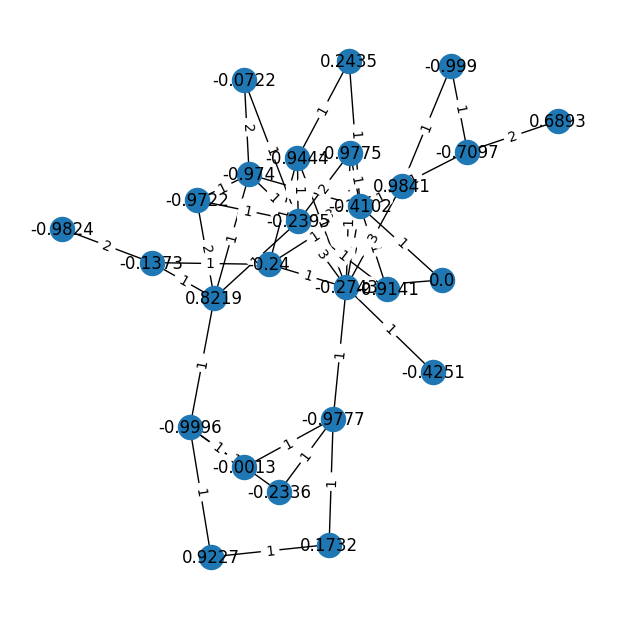

In [5]:
plt.figure(figsize = (6,6))
thread = getThread(0,data)
G, nodeDict, edgeDict, centrality = makeGraph(thread)

pos=nx.kamada_kawai_layout(G)
nx.draw(G, pos = pos, labels = nodeDict,  cmap='RdYlGn')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeDict);

### Feature Creation

In [7]:
deltaSentiments = []
connectionSentiments = []
connectionCentrality = []
meanSentiment = []
messageLength = []
threadLength = []
edgeDegree = []
posterNumber = []
threadID = []


for i in range(0,len(threads)):
    thread = getThread(i,data)
   
    for i in range(0,len(thread)-1):
        G, nodeDict, edgeDict, centrality = makeGraph(thread.iloc[:i+1])
        
        #deltaSentiments.append(np.mean(thread["AllenNLP"].iloc[0:i]))
        deltaSentiments.append(thread["AllenNLP"].iloc[i+1])
        connectionCentrality.append(centrality[thread["MemberID"].iloc[i]])
        meanSentiment.append(np.mean(thread["AllenNLP"].iloc[0:i]))
        messageLength.append(len(str(thread["Message"].iloc[i])))
        threadLength.append(i+1)
        connectionSentiments.append(thread["AllenNLP"].iloc[i])
        edgeDegree.append(G.degree(thread["MemberID"].iloc[i]))
        posterNumber.append(thread["MemberID"].iloc[i])
        threadID.append(thread["ThreadID"].iloc[i])



C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == member

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == member

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Da

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == member

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == member

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == member

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == member

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == member

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == member

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

KeyboardInterrupt: 

In [ ]:
features = pd.DataFrame(np.array([threadID,threadLength,posterNumber,connectionCentrality, messageLength,
                                  connectionSentiments, edgeDegree,meanSentiment,deltaSentiments]).T,
                       columns = ["threadID","threadLength","posterNumber","centrality","messageLength","sentiment","degree","meanSentiment","deltaSentiments"])

In [ ]:
features.replace([np.inf, -np.inf], 1, inplace=True)
features.dropna(inplace=True)


In [8]:
features = pd.read_csv("features.csv", index_col =0)
features.head()

,threadID,threadLength,posterNumber,centrality,messageLength,sentiment,degree,meanSentiment,deltaSentiments
1,240.0,2.0,0.0,1.0,23908.0,0.142836,0.0,-0.183807,-0.020485
2,240.0,3.0,0.0,1.0,3968.0,0.181680,0.0,-0.020485,0.046903
3,240.0,4.0,0.0,1.0,3469.0,0.370321,0.0,0.046903,0.127758
4,240.0,5.0,0.0,1.0,97.0,-0.005715,0.0,0.127758,0.101063
5,240.0,6.0,7.0,1.0,380.0,0.198179,1.0,0.101063,0.117249


threads = features["threadID"].unique()

negative = []
positive = []

for i in threads:
    if np.mean(features[features["threadID"] ==i]["meanSentiment"]) >=0:
        positive.append(i)
    else:
        negative.append(i)

#### Balance features

balanceThreads = np.random.choice(negative, size = len(positive))

negFeatures = features[features["threadID"].isin(balanceThreads)]
posFeatures = features[features["threadID"].isin(positive)]

features = pd.concat([negFeatures,posFeatures])

### Model

In [9]:
import tensorflow as tf
from keras.layers import Dense,LSTM,Embedding, InputLayer, BatchNormalization,Dropout
from keras.models import Sequential,Model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [83]:
mask = []

for i in threads:

    thread = features[features["threadID"] == i]
    mask.append(thread["threadLength"] < int(.5*len(thread)))
mask = np.concatenate(mask)

In [84]:
xTrain = features[features.columns[1:-1]][mask]
yTrain = features[features.columns[-1]][mask]
xTest = features[features.columns[1:-1]][~mask]
yTest = features[features.columns[-1]][~mask]

"""
xScaler = StandardScaler().fit(xTrain)
yScaler = StandardScaler().fit(yTrain.to_numpy().reshape(-1,1))

xTrain = xScaler.transform(xTrain)
yTrain = yScaler.transform(yTrain.to_numpy().reshape(-1,1))

xTest = xScaler.transform(xTest)
yTest = yScaler.transform(yTest.to_numpy().reshape(-1,1))


"""



'\nxScaler = StandardScaler().fit(xTrain)\nyScaler = StandardScaler().fit(yTrain.to_numpy().reshape(-1,1))\n\nxTrain = xScaler.transform(xTrain)\nyTrain = yScaler.transform(yTrain.to_numpy().reshape(-1,1))\n\nxTest = xScaler.transform(xTest)\nyTest = yScaler.transform(yTest.to_numpy().reshape(-1,1))\n\n\n'

In [85]:
xTrain = xTrain.to_numpy().reshape(-1,1,7)
xTest = xTest.to_numpy().reshape(-1,1,7)

In [ ]:
batch = 32
epoch = 10
act = 'tanh'

model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(128, activation=act, return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(128, activation=act, return_sequences=False))
model.add(Dropout(.2))
model.add(Dense(100,activation=act))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics = ['mape'])
model.fit(xTrain, yTrain, batch_size= batch, epochs=epoch, verbose=1)



Epoch 1/10
1935/1935 [==============================] - 11s 4ms/step - loss: 0.0084 - mape: 7789.2969
Epoch 2/10
1935/1935 [==============================] - 8s 4ms/step - loss: 0.0069 - mape: 9673.9893
Epoch 3/10
1935/1935 [==============================] - 8s 4ms/step - loss: 0.0064 - mape: 7453.8838
Epoch 4/10
1935/1935 [==============================] - 8s 4ms/step - loss: 0.0063 - mape: 16319.8613
Epoch 5/10
1935/1935 [==============================] - 7s 4ms/step - loss: 0.0063 - mape: 6389.9243
Epoch 6/10
1935/1935 [==============================] - 8s 4ms/step - loss: 0.0061 - mape: 8964.0557
Epoch 7/10
1935/1935 [==============================] - 8s 4ms/step - loss: 0.0060 - mape: 7343.2383
Epoch 8/10
1728/1935 [=========================>....] - ETA: 0s - loss: 0.0061 - mape: 11024.5928

### Analysis

In [15]:
def featureExtract(i):
    deltaSentiments = []
    connectionSentiments = []
    connectionCentrality = []
    meanSentiment = []
    messageLength = []
    threadLength = []
    edgeDegree = []
    posterNumber = []
    threadID = []


    thread = getThread(i,data)

    for i in range(0,len(thread)-1):
        G, nodeDict, edgeDict, centrality = makeGraph(thread.iloc[:i+1])

        deltaSentiments.append(np.mean(thread["AllenNLP"].iloc[0:i+1]))
        #deltaSentiments.append(thread["AllenNLP"].iloc[i+1])
        connectionCentrality.append(centrality[thread["MemberID"].iloc[i]])
        meanSentiment.append(np.mean(thread["AllenNLP"].iloc[0:i]))
        messageLength.append(len(str(thread["Message"].iloc[i])))
        threadLength.append(i+1)
        connectionSentiments.append(thread["AllenNLP"].iloc[i])
        edgeDegree.append(G.degree(thread["MemberID"].iloc[i]))
        posterNumber.append(thread["MemberID"].iloc[i])
        threadID.append(thread["ThreadID"].iloc[i])

    features = pd.DataFrame(np.array([threadID,threadLength,posterNumber,connectionCentrality, messageLength,
                                  connectionSentiments, edgeDegree,meanSentiment,deltaSentiments]).T,
                       columns = ["threadID","threadLength","posterNumber","centrality","messageLength","sentiment","degree","meanSentiment","deltaSentiments"])
    
    features.replace([np.inf, -np.inf], 1, inplace=True)
    features.dropna(inplace=True)

    return features

In [ ]:
yPred = model.predict(xTest).reshape(-1,1)


In [ ]:
r2_score(yTest,yPred)

In [ ]:
plt.hist(yTest.to_numpy().reshape(-1,1) - yPred);


In [47]:
test = featureExtract(-1)

C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_12240\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (be

In [ ]:
predTest = test[test.columns[1:-1]]

In [ ]:
preds = model.predict(predTest.to_numpy().reshape(-1,1,7))

In [ ]:
t = np.arange(0,len(test))
plt.plot(t,test["meanSentiment"], label = "Data")
plt.plot(t,preds.reshape(1,-1)[0], label = "Model")
plt.title("Thread Sentiment Over Time")
plt.xlabel("Time (Thread Interactions)")
plt.ylabel("Sentiment")
plt.legend()

### Forecasting

In [72]:
def getBootStrap(predTest, testSample):

    bootStrap = pd.DataFrame(testSample.iloc[-int(.25*len(testSample)):]).sample(n = len(predTest)-len(testSample),replace=True)
    bootStrap.reset_index(drop = True,inplace = True)
    bootStrap["threadLength"] = np.arange(len(testSample), len(bootStrap)+len(testSample))

    pred = model.predict(testSample.iloc[-1].to_numpy().reshape(-1,1,7), verbose = False)
    bootStrap.iloc[0]["meanSentiment"] = pred

    for i in range(0,len(bootStrap)-1):
        pred = model.predict(bootStrap.iloc[i].to_numpy().reshape(-1,1,7), verbose = False)
        bootStrap.iloc[i+1]["meanSentiment"] = pred

    return  bootStrap["meanSentiment"]

In [ ]:
test = featureExtract(-10)
predTest = test[test.columns[1:-1]]
testSample = predTest.iloc[0:int(.8*len(predTest))]

samples = []
for i in range(0,10):
    samples.append(getBootStrap(predTest, testSample))
    
forecast= np.mean(samples,axis = 0)

t = np.arange(0,len(testSample))
forecastT = np.arange(len(testSample), len(forecast) +len(testSample))

plt.plot(predTest["threadLength"] -2, predTest["meanSentiment"], label = "Data")
plt.plot(t,testSample["meanSentiment"], label = "Seen Data")
plt.plot(forecastT, forecast, label = "Forecast")
plt.title("Thread Sentiment Over Time")
plt.xlabel("Time (Thread Interactions)")
plt.ylabel("Sentiment")
plt.legend()

In [ ]:
error = []
for i in range(len(error),len(threads)):
    test = featureExtract(i)
    predTest = test[test.columns[1:-1]]
    testSample = predTest.iloc[0:int(.8*len(predTest))]

    samples = []

    for i in range(0,10):

        samples.append(getBootStrap(predTest, testSample))

    forecast = np.mean(samples, axis = 0)
    error.append(mean_squared_error(predTest["meanSentiment"].iloc[len(testSample):],forecast))

In [ ]:
print(np.mean(error))

plt.hist(error)